In [1]:
from imports import *
import scikit_posthocs as sp
from statannotations.Annotator import Annotator

def discard_border(state, t):
    state.start = state.start + (t * 1_000_000)
    state.end = state.end - (t * 1_000_000)


def compute_eib(neurons, metadata, stru, start=0, stop=None, binSize=0.025, nbins=None,as_tsd = False):
    activity = bk.compute.binSpikes(neurons, start=start, stop=stop,binSize = binSize, nbins=nbins, as_Tsd=True)
    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')
    e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values.astype(np.int64), 1)
    i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values.astype(np.int64), 1)
    
    eib = e_spikes / (e_spikes + i_spikes)
    # print('ispikes',i_spikes)
    eib[~np.isfinite(eib)] = np.nan
    
    if as_tsd: eib = nts.Tsd(activity.times(),eib)
    return eib


def eib_intervals_old(neurons,metadata,stru,intervals):

    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')

    activity = bk.compute.bin_by_intervals(neurons,intervals,as_Tsd=True)
    e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values.astype(np.int64), 1)
    i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values.astype(np.int64), 1)

    return (e_spikes)/(e_spikes+i_spikes)

def eib_intervals(neurons,metadata,stru,intervals,nbins,norm = False,baseline = None):
    if len(intervals) == 0:
        eib = np.empty(shape = nbins)
        eib.fill(np.nan)
        return eib
    if norm:
        if baseline is None:
            tmp_eib = compute_eib(neurons,metadata,start = 0,stop = None,binSize = 10 ,stru = stru)
        else:
            tmp_eib = compute_eib(neurons,metadata,start = 0,stop = None,binSize = 10 ,stru = stru,as_tsd=True).restrict(baseline)
        mean = np.nanmean(tmp_eib)
        std = np.nanstd(tmp_eib)

    intervals_eib_matrix = []
    for s,e in tqdm(intervals.as_units('s').iloc(),total = len(intervals)):
        inter = nts.IntervalSet(s,e,time_units='s')
        eib_ = compute_eib(neurons,metadata,start = s,stop = e,nbins = nbins,stru = stru)

        if norm: eib_ = (eib_-mean)/std

        intervals_eib_matrix.append(eib_)
    if nbins == 1:
        intervals_eib_matrix = np.hstack(intervals_eib_matrix)
    return intervals_eib_matrix

In [2]:
def main(base_folder, local_path, *args, **kwargs):
    stru = kwargs['stru']
    nbins = kwargs['nbins']
    min_duration_epoch = kwargs['min_duration']
    time_from_border = kwargs['time_from_border']
    norm = kwargs['norm']
    baseline = kwargs['baseline']

    bk.load.current_session_linux(base_folder=base_folder,local_path=local_path)
    neurons,metadata = bk.load.spikes()
    
    if np.sum((metadata.Region == stru) & (metadata.Type == 'Int')) <3:
        raise IndexError('Less than 3 interneurons')

    # if len(neurons[(metadata.Region == stru)& (metadata.Type == 'Pyr')])<11:
    #     raise Exception('Not Enough Neurons')
    
    states = bk.load.states(True)
    if baseline == 'All':
        baseline_intervals = states['REM'].union(states['REM']).union(states['WAKE_HOMECAGE'])
    elif baseline is not None:
        baseline_intervals = states[baseline]
    else:
        baseline_intervals = None

    # baseline_eib = eib_intervals(neurons,metadata,stru,baseline_intervals,3)
    # baseline_eib = compute_eib(neurons,metadata,stru,binSize=3,as_tsd=True) # for normalization of the whole session

    for s in ['wake','drowsy']: states.pop(s)

    all_average_eib = {}
    df = pd.DataFrame()
    for k,state in states.items():
        state = state.drop_short_intervals(min_duration_epoch[k],'s').reset_index(drop = True)
        discard_border(state,time_from_border[k]) # We remove what is close to transition as the sleep scoring might not be perfect
        all_average_eib[k] = eib_intervals(neurons,metadata,stru,state,nbins[k],norm = norm,baseline=baseline_intervals)
        if nbins[k] == 1:  
            df_ = pd.DataFrame(all_average_eib[k],columns=['EIB'])
        elif nbins[k]==3:
            df_ = pd.DataFrame(all_average_eib[k],columns=['First','Middle','Last'])
        else:
            df_ = pd.DataFrame([all_average_eib[k]]).T
            df_.columns = ['Dynamic']

        df_['State'] = k
        df= pd.concat((df,df_))
    df['Rat'] = bk.load.rat
    df['Day'] = bk.load.day
    df['nPyr'] = np.sum((metadata.Region == stru) & (metadata.Type == 'Pyr'))
    df['nInt'] = np.sum((metadata.Region == stru) & (metadata.Type == 'Int'))

    return df

In [145]:
def merge(batch_output):
    states_eib = {'REM': [],
                  'NREM': [],
                  'WAKE_HOMECAGE': []}
    metadata = pd.DataFrame()
    for k, b in batch_output.items():
        metadata = pd.concat((metadata, b[1]))
        for kk, state_eib in b[0].items():
            states_eib[kk].append(state_eib)
    for k, state_eib in states_eib.items():
        states_eib[k] = np.hstack(state_eib)
    return states_eib


## Compare Between State

In [72]:
kwargs = {'stru': 'BLA',
          'nbins':
          {
              'REM': 1,
              'NREM': 1,
              'WAKE_HOMECAGE': 1
          },
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'time_from_border':
          {'REM': 0,
           'NREM': 0,
           'WAKE_HOMECAGE': 0
           },
          'norm': True,
          'baseline': 'All'
          }
bk.load.current_session_linux()
batch, metadata = bk.load.batch(main, **kwargs)
df_norm = pd.concat(batch)


kwargs = {'stru': 'BLA',
          'nbins':
          {
              'REM': 1,
              'NREM': 1,
              'WAKE_HOMECAGE': 1
          },
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'time_from_border':
          {'REM': 0,
           'NREM': 0,
           'WAKE_HOMECAGE': 0
           },
           'norm':False,
           'baseline':None
          }
bk.load.current_session_linux()
batch, metadata = bk.load.batch(main, **kwargs)
df_no_norm = pd.concat(batch)

100%|██████████| 61/61 [03:43<00:00,  3.66s/it]

Batch finished in 223.5643060207367
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
57.377049180327866 %


In [127]:
sess = df_no_norm.reset_index()['level_0'].unique()

In [128]:
nPyr = []
nInt = []
for s in sess:
    nPyr.append(df_no_norm.loc[s].nPyr.unique()[0])
    nInt.append(df_no_norm.loc[s].nInt.unique()[0])

n_neurons_crit_pyr = pd.DataFrame(np.array([sess,nPyr,nInt]).T,columns=['Sess','nPyr','nInt'])
pd.merge(n_neurons_crit_pyr,n_neurons_crit_inter,'outer',on='Sess',suffixes=['PyrCriteria','IntCriteria'])

In [27]:
df = df_norm
df = df.reset_index(level=0,names = 'session')
scipy.stats.kruskal(df['EIB'][df.State == 'NREM'],
                    df['EIB'][df.State == 'REM'],
                    df['EIB'][df.State == 'WAKE_HOMECAGE'])
pairs = list(itertools.combinations(df.State.unique(),2))

In [24]:
sp.posthoc_dunn(df,group_col='State',val_col='EIB',p_adjust='bonferroni')

,NREM,REM,WAKE_HOMECAGE
NREM,1.000000,0.032934,0.077682
REM,0.032934,1.000000,1.000000
WAKE_HOMECAGE,0.077682,1.000000,1.000000


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

REM vs. WAKE_HOMECAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.510e-08 U_stat=3.983e+04
NREM vs. REM: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.672e-03 U_stat=4.783e+04
NREM vs. WAKE_HOMECAGE: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.655e-22 U_stat=5.524e+04


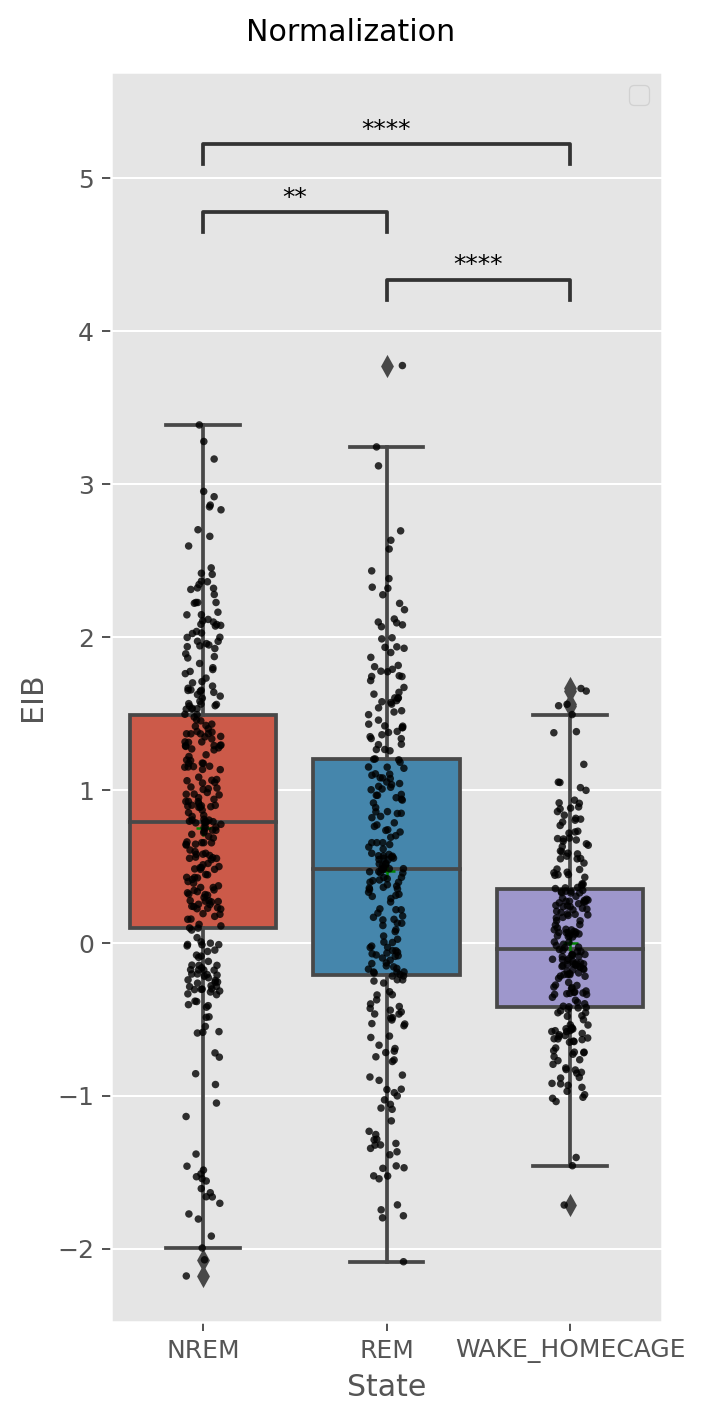

In [44]:
fig,ax = plt.subplots(1,1,dpi = 180,figsize = (4,8))
sns.boxplot(data=df,x='State',y='EIB',showmeans = True,meanprops = {'marker':'+',"markeredgecolor":'green'},ax = ax,order = ['NREM','REM','WAKE_HOMECAGE'])
sns.stripplot(data=df,x='State',y='EIB',ax = ax,order = ['NREM','REM','WAKE_HOMECAGE'],color='black',size = 3,alpha = 0.8)

# sns.boxplot(data=df,x='session',y='EIB',hue = 'State',showmeans = True,meanprops = {'marker':'+',"markeredgecolor":'green'},ax = ax,hue_order = ['NREM','REM','WAKE_HOMECAGE'])
# sns.stripplot(data=df,x='session',y='EIB',hue = 'State',ax = ax,hue_order = ['NREM','REM','WAKE_HOMECAGE'],dodge=True,size=2,alpha = 0.8,color = 'black')
# plt.xticks(rotation = 'vertical')

plotting_params = {'data': df,
                   'y': 'EIB',
                   'x':'State',
                   'order':['NREM','REM','WAKE_HOMECAGE'],
                   'ax':ax}

annotator = Annotator(pairs = pairs,**plotting_params)
annotator.configure(test="Mann-Whitney",comparisons_correction = 'Bonferroni').apply_and_annotate()

plt.suptitle('Normalization')
ax.legend([])
plt.tight_layout()

## Compare between thirds

In [46]:
kwargs = {'stru': 'BLA',
          'nbins':
          {
              'REM': 3,
              'NREM': 3,
              'WAKE_HOMECAGE': 3
          },
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'time_from_border':
          {'REM': 5,
           'NREM': 20,
           'WAKE_HOMECAGE': 20
           },
          'norm': True,
          'baseline': 'All'
          }
bk.load.current_session_linux()
batch, metadata = bk.load.batch(main, **kwargs)
df_norm = pd.concat(batch)


100%|██████████| 61/61 [02:06<00:00,  2.07s/it]

Batch finished in 126.35292148590088
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
57.377049180327866 %


In [47]:
pairs = [
    [('NREM', 'First'), ('NREM', 'Middle')],
    [('NREM', 'First'), ('NREM', 'Last')],
    [('NREM', 'Middle'), ('NREM', 'Last')],

    [('REM', 'First'), ('REM', 'Middle')],
    [('REM', 'First'), ('REM', 'Last')],
    [('REM', 'Middle'), ('REM', 'Last')],

    [('WAKE_HOMECAGE', 'First'), ('WAKE_HOMECAGE', 'Middle')],
    [('WAKE_HOMECAGE', 'First'), ('WAKE_HOMECAGE', 'Last')],
    [('WAKE_HOMECAGE', 'Middle'), ('WAKE_HOMECAGE', 'Last')]
]

df = df_norm
for state in ['NREM', 'REM', 'WAKE_HOMECAGE']:
    print(state,scipy.stats.friedmanchisquare(df['First'][df.State == state],
                                  df['Middle'][df.State == state],
                                  df['Last'][df.State == state]))

NREM FriedmanchisquareResult(statistic=36.41640378548891, pvalue=1.2367399577324687e-08)
REM FriedmanchisquareResult(statistic=1.8467432950187685, pvalue=0.3971776379921535)
WAKE_HOMECAGE FriedmanchisquareResult(statistic=2.111111111111313, pvalue=0.3479990407922201)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

REM_Middle vs. REM_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=1.577e+04
WAKE_HOMECAGE_First vs. WAKE_HOMECAGE_Middle: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=1.368e+04
WAKE_HOMECAGE_Middle vs. WAKE_HOMECAGE_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=1.230e+04
NREM_First vs. NREM_Middle: Wilcoxon test (paired samples) with Bonferroni correction, P_val:8.129e-03 Stat=1.978e+04
NREM_Middle vs. NREM_Last: Wilcoxon test (paired samples) with Bonferroni correction, P_val:2.226e-03 Stat=1.922e+04
REM_First vs. REM_Middle: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.000e+00 Stat=1.654e+04
WAKE_HOMECAGE_First vs. WAKE_HOMECAGE_Last: Wilcoxon test (paired samples) with Bo

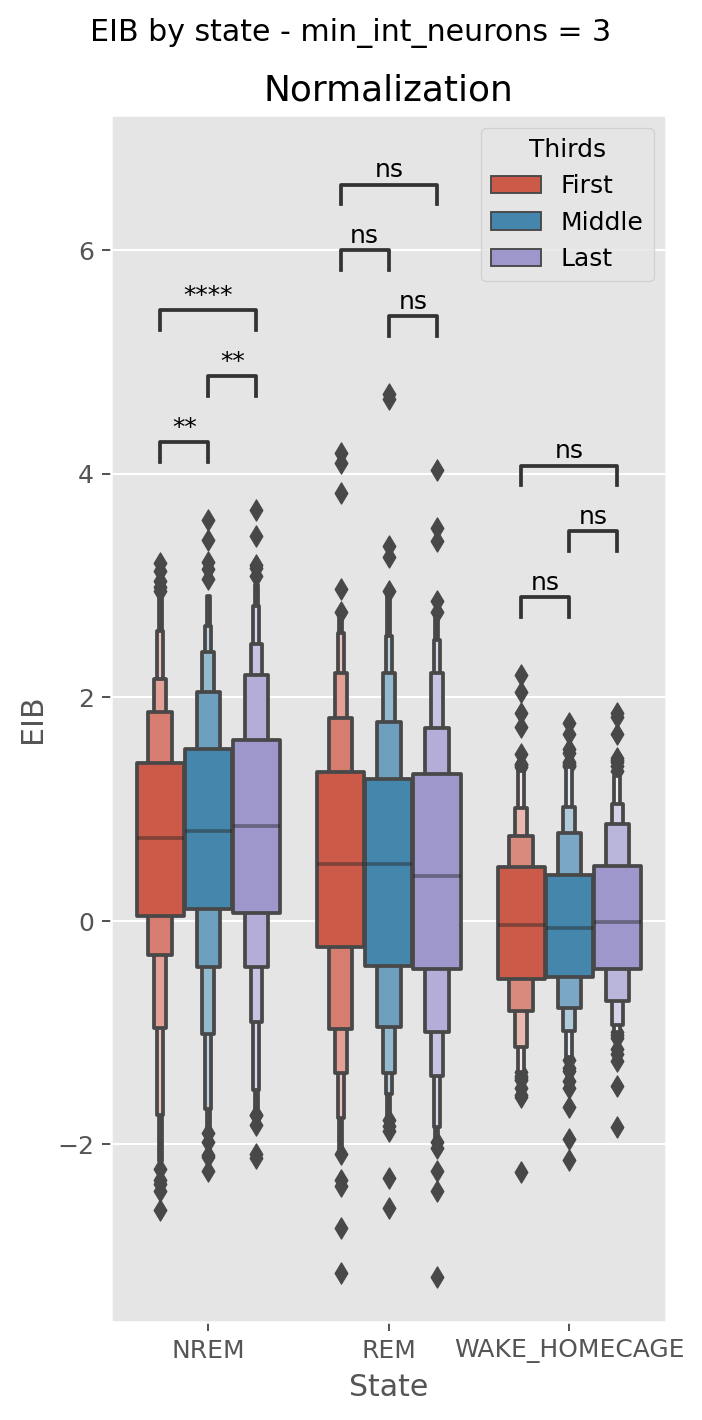

In [48]:
df = df.melt(id_vars=['Rat','Day','State'],var_name='Thirds',value_name='EIB',value_vars=['First','Middle','Last'])
fig,ax = plt.subplots(1,1,figsize=(4,8),dpi = 180)
plotting_params = {'data': df,
                   'y': 'EIB',
                   'x':'State',
                   'dodge':True,
                   'hue':'Thirds',
                   'order':['NREM','REM','WAKE_HOMECAGE'],
                   'ax':ax}
sns.boxenplot(**plotting_params)
annotator = Annotator(pairs = pairs,**plotting_params)
annotator.configure(test="Wilcoxon",comparisons_correction = 'Bonferroni').apply_and_annotate()
ax.set_title('Normalization')
plt.suptitle(f'EIB by state - min_int_neurons = 3')
plt.tight_layout()
# plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/synchrony/Parts/sync_state_thirds_10neurons_100ms.svg')

In [11]:
kwargs = {'stru': 'BLA',
          'nbins':
          {
              'REM': 30,
              'NREM': 30,
              'WAKE_HOMECAGE': 30
          },
          'min_duration':
          {
              'REM': 30,
              'NREM': 200,
              'WAKE_HOMECAGE': 200
          },
          'time_from_border':
          {'REM': 5,
           'NREM': 20,
           'WAKE_HOMECAGE': 20
           },
          'norm': True,
          'baseline': 'All'
          }
bk.load.current_session_linux()
batch, metadata = bk.load.batch(main, **kwargs)
# main(bk.load.base,'Rat08/Rat08-20130713',**kwargs)
df_norm = pd.concat(batch)

100%|██████████| 61/61 [02:59<00:00,  2.94s/it]

Batch finished in 179.2631471157074
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
57.377049180327866 %


In [1]:
%matplotlib qt

: 

LinregressResult(slope=0.006409113028769033, intercept=0.661980776988554, rvalue=0.0460861860752505, pvalue=6.9215290641102245e-06, stderr=0.0014246916460974582, intercept_stderr=0.02405859477793353)
LinregressResult(slope=-0.005212417323988653, intercept=0.5224230996306732, rvalue=-0.028153365890302602, pvalue=0.012727265297198805, stderr=0.002091757162215062, intercept_stderr=0.03532324912371236)
LinregressResult(slope=0.0029163613224268098, intercept=-0.05166142107042103, rvalue=0.029098140196868724, pvalue=0.014765401699107054, stderr=0.0011958741522189052, intercept_stderr=0.020194581552049975)


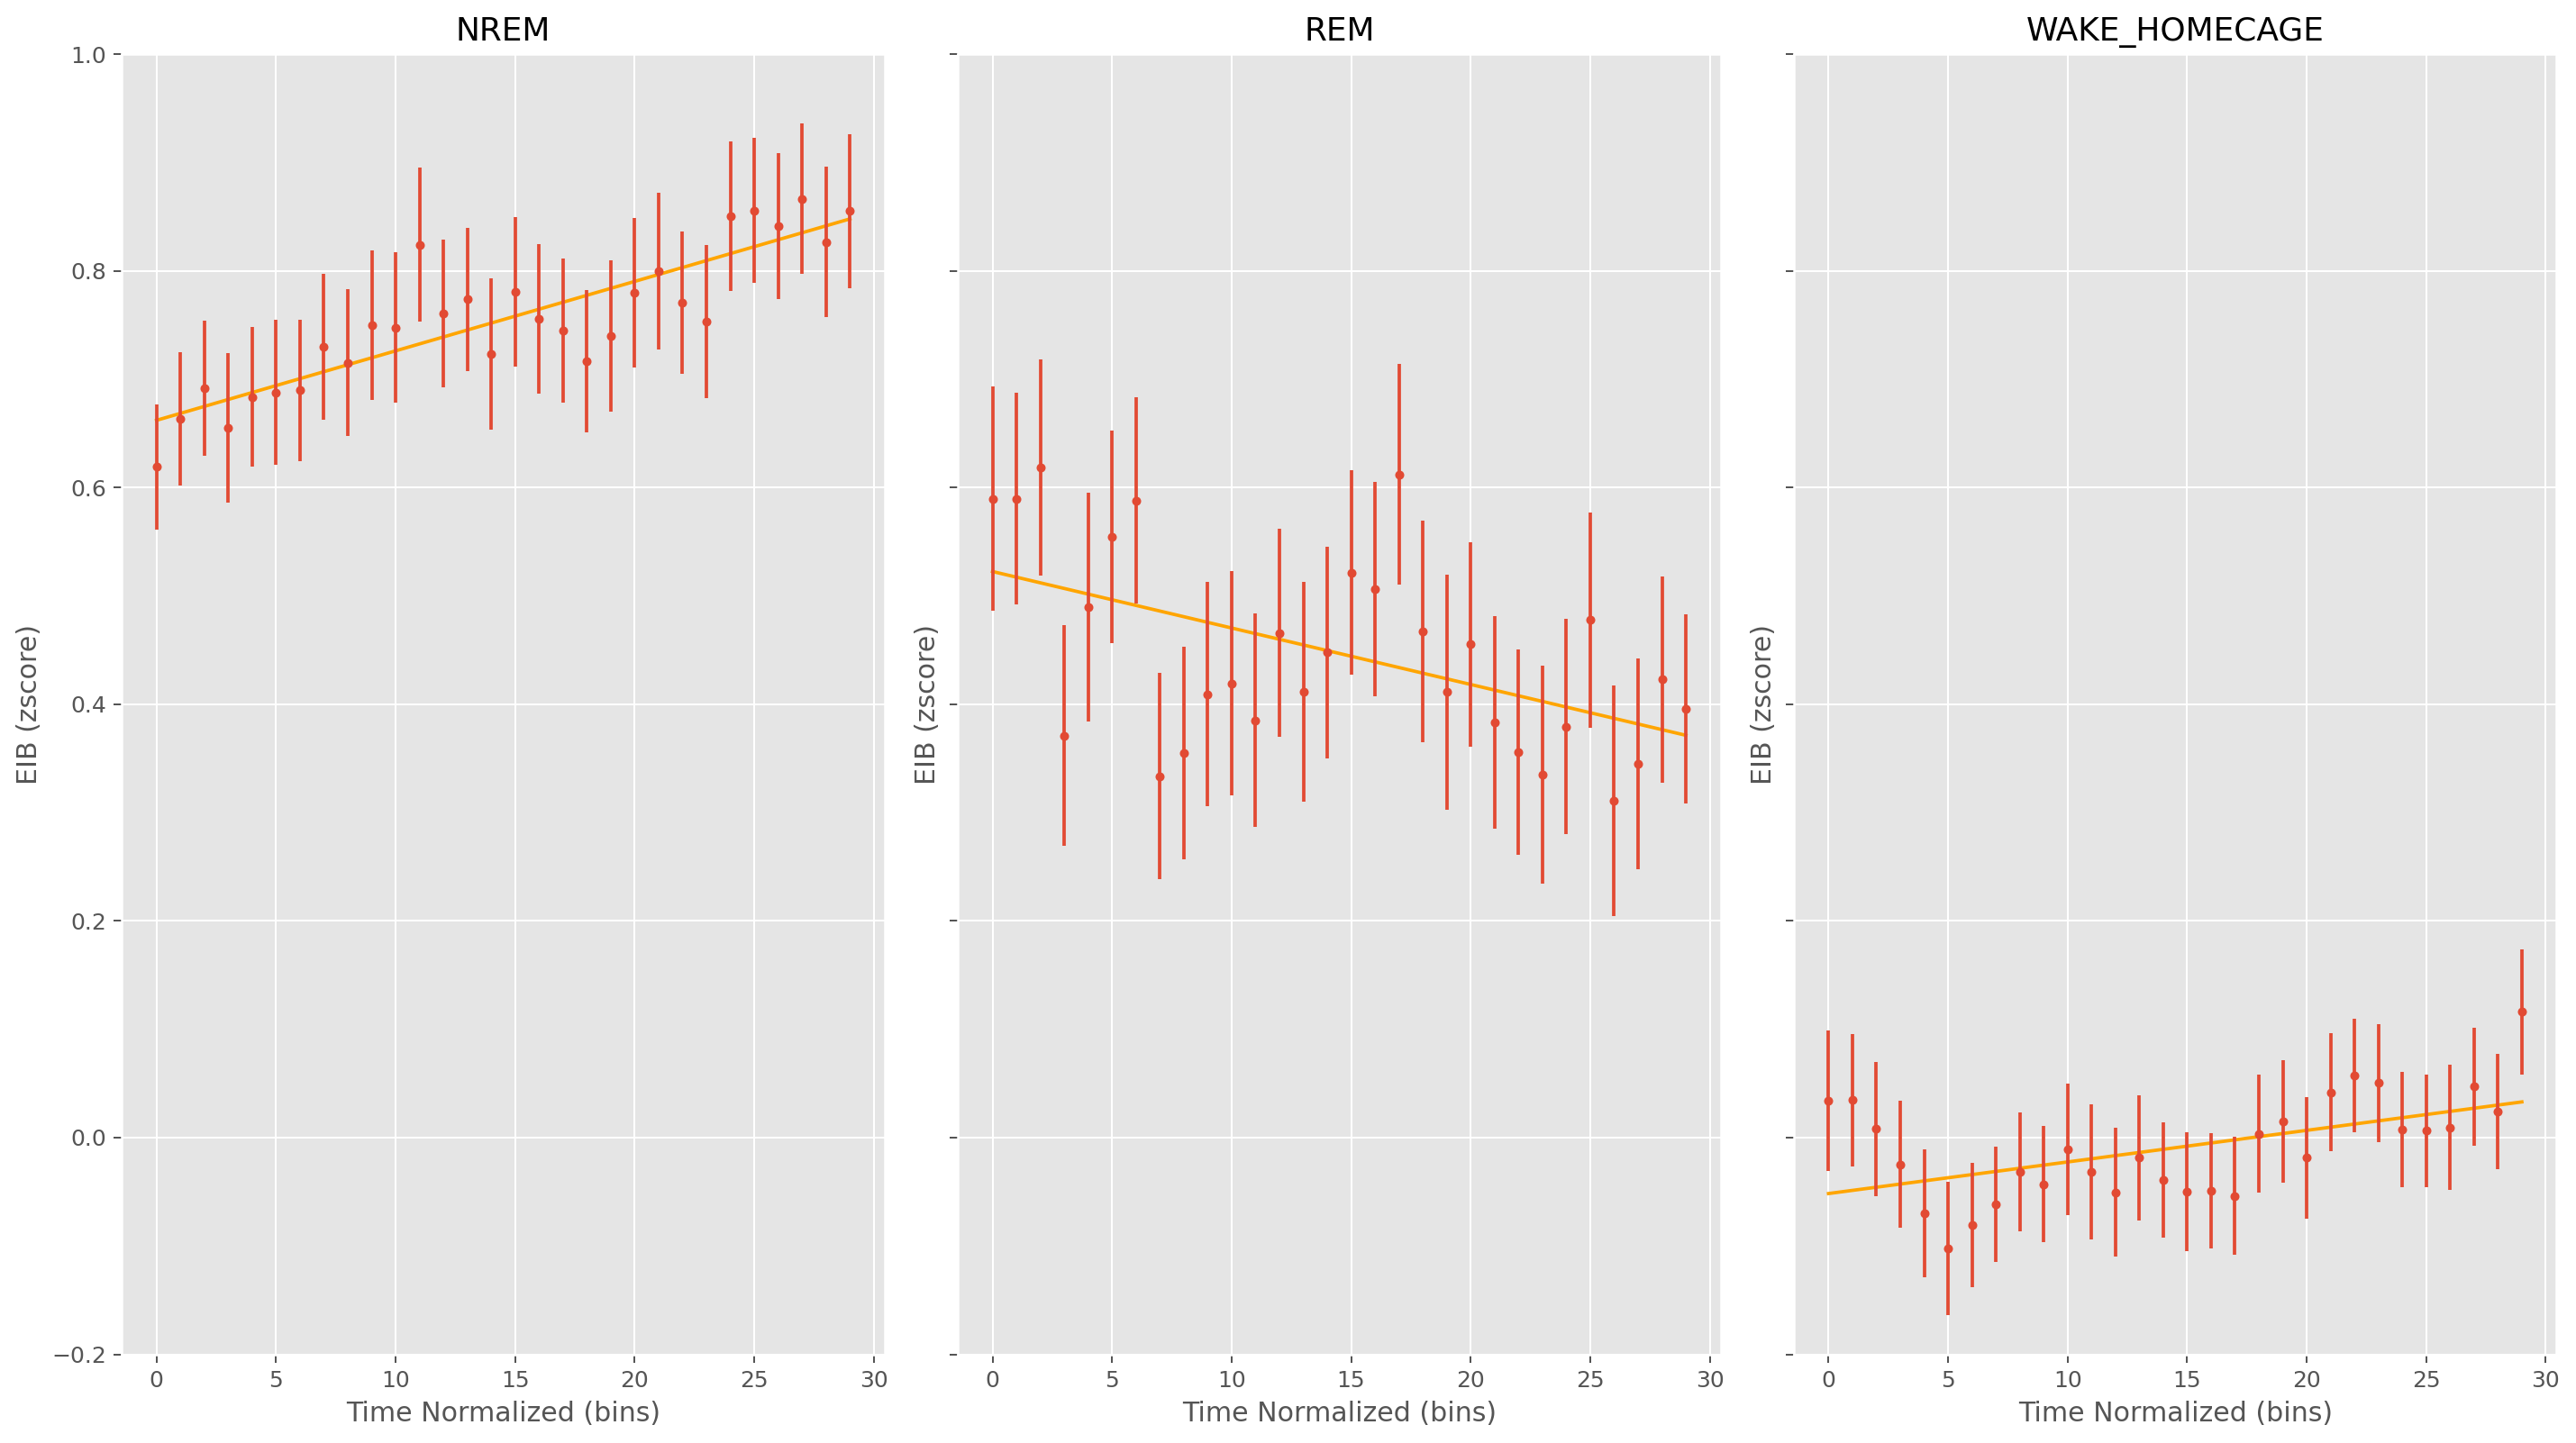

In [13]:
df = df_norm
fig,ax = plt.subplots(1,3,dpi = 180,sharey=True,figsize = (16,9))
for i,state in enumerate(['NREM','REM','WAKE_HOMECAGE']):
    y = np.vstack(df.Dynamic[df.State == state].values)
    x = range(y.shape[1])

    # bk.plot.curve_and_shades(range(y.shape[1]),y,'sem',ax=ax[i])
    all_eib = np.array([[],[]])
    for j in y:
        all_eib = np.hstack((all_eib,np.array([x,j])))
        # ax[i].scatter(x,j,color = 'grey')
    

    means = [np.mean(all_eib[1,:][np.where(all_eib[0,:] == i)])for i in x]
    std = [scipy.stats.sem(all_eib[1,:][np.where(all_eib[0,:] == i)])for i in x]
    reg = scipy.stats.linregress(all_eib)


    print(reg)
    reg_y = (reg.slope * x) + reg.intercept
    ax[i].plot(x,reg_y,'orange')
    ax[i].errorbar(x,means,std,linestyle='None', marker='.')
    
    ax[i].set_title(state)
    ax[i].set_ylim(-0.2,1)
    ax[i].set_xlabel('Time Normalized (bins)')
    ax[i].set_ylabel('EIB (zscore)')
plt.tight_layout()

In [ ]:
def main(base_folder,local_path,**kwargs):
    stru = kwargs['stru']
    norm = kwargs['norm']

    bk.load.current_session_linux(base_folder=base_folder,local_path=local_path)
    neurons,metadata = bk.load.spikes()
    
    if np.sum((metadata.Region == 'BLA') & (metadata.Type == 'Int')) <3:
        raise IndexError('Less than 5 interneurons')
    
    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')

    states = bk.load.states(True)
    for s in ['wake','drowsy']: states.pop(s)
    
    baseline_intervals = states['NREM'].union(states['NREM']).union(states['WAKE_HOMECAGE'])
    baseline_eib = compute_eib(neurons,metadata,'BLA',binSize=2,as_tsd=True).restrict(baseline_intervals)

    # baseline_intervals = pd.concat((states['REM'],states['NREM'],states['WAKE_HOMECAGE']))
    # baseline_eib = eib_intervals(neurons,metadata,'BLA',baseline_intervals,1)
    baseline_mean = np.nanmean(baseline_eib)
    baseline_std = np.nanstd(baseline_eib)

    print(baseline_std)
    all_average_eib = {}
    for k,state in states.items():
        state = state.drop_short_intervals(50,time_units = 's').reset_index(drop = True)
        activity = bk.compute.bin_by_intervals(neurons,state,as_Tsd=True)
        e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values.astype(np.int64), 1)
        i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values.astype(np.int64), 1)
        all_average_eib[k] = (e_spikes)/(e_spikes+i_spikes)
        if norm: all_average_eib[k] = (all_average_eib[k] - baseline_mean)/baseline_std
    


    df = {}
    for state in states:
        df[state] = pd.DataFrame()
        df[state]['EIB'] = all_average_eib[state]
        df[state]['State'] = state
        print(df[state])
    df = pd.concat(df)
    df['Rat'] = bk.load.rat
    df['Day'] = bk.load.day
    df = df[['Rat','Day','State','EIB']].reset_index(drop = True)
    return df

In [81]:
kwargs = {'stru':'BLA','norm':True}
batch,meta = bk.load.batch(main,**kwargs)
# main(bk.load.base,'Rat08/Rat08-20130712',**kwargs)

100%|██████████| 61/61 [03:00<00:00,  2.96s/it]

Batch finished in 180.306405544281
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140624', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'Rat11-20150403']
57.377049180327866 %


In [51]:
from scipy.stats import bartlett
from scipy.stats import shapiro
from scipy.stats import levene

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.formula.api import glm
from statsmodels.formula.api import gls
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.multicomp import pairwise_tukeyhsd

             df     sum_sq   mean_sq         F    PR(>F)
C(State)    2.0   0.015124  0.007562  0.558555  0.572255
Residual  809.0  10.952547  0.013538       NaN       NaN
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1     group2    meandiff p-adj   lower  upper  reject
----------------------------------------------------------
  NREM           REM  -0.0029 0.9515 -0.0258 0.0199  False
  NREM WAKE_HOMECAGE   0.0078 0.7157 -0.0157 0.0314  False
   REM WAKE_HOMECAGE   0.0107 0.5612 -0.0139 0.0353  False
----------------------------------------------------------
[0.95152386 0.71570082 0.56122576]


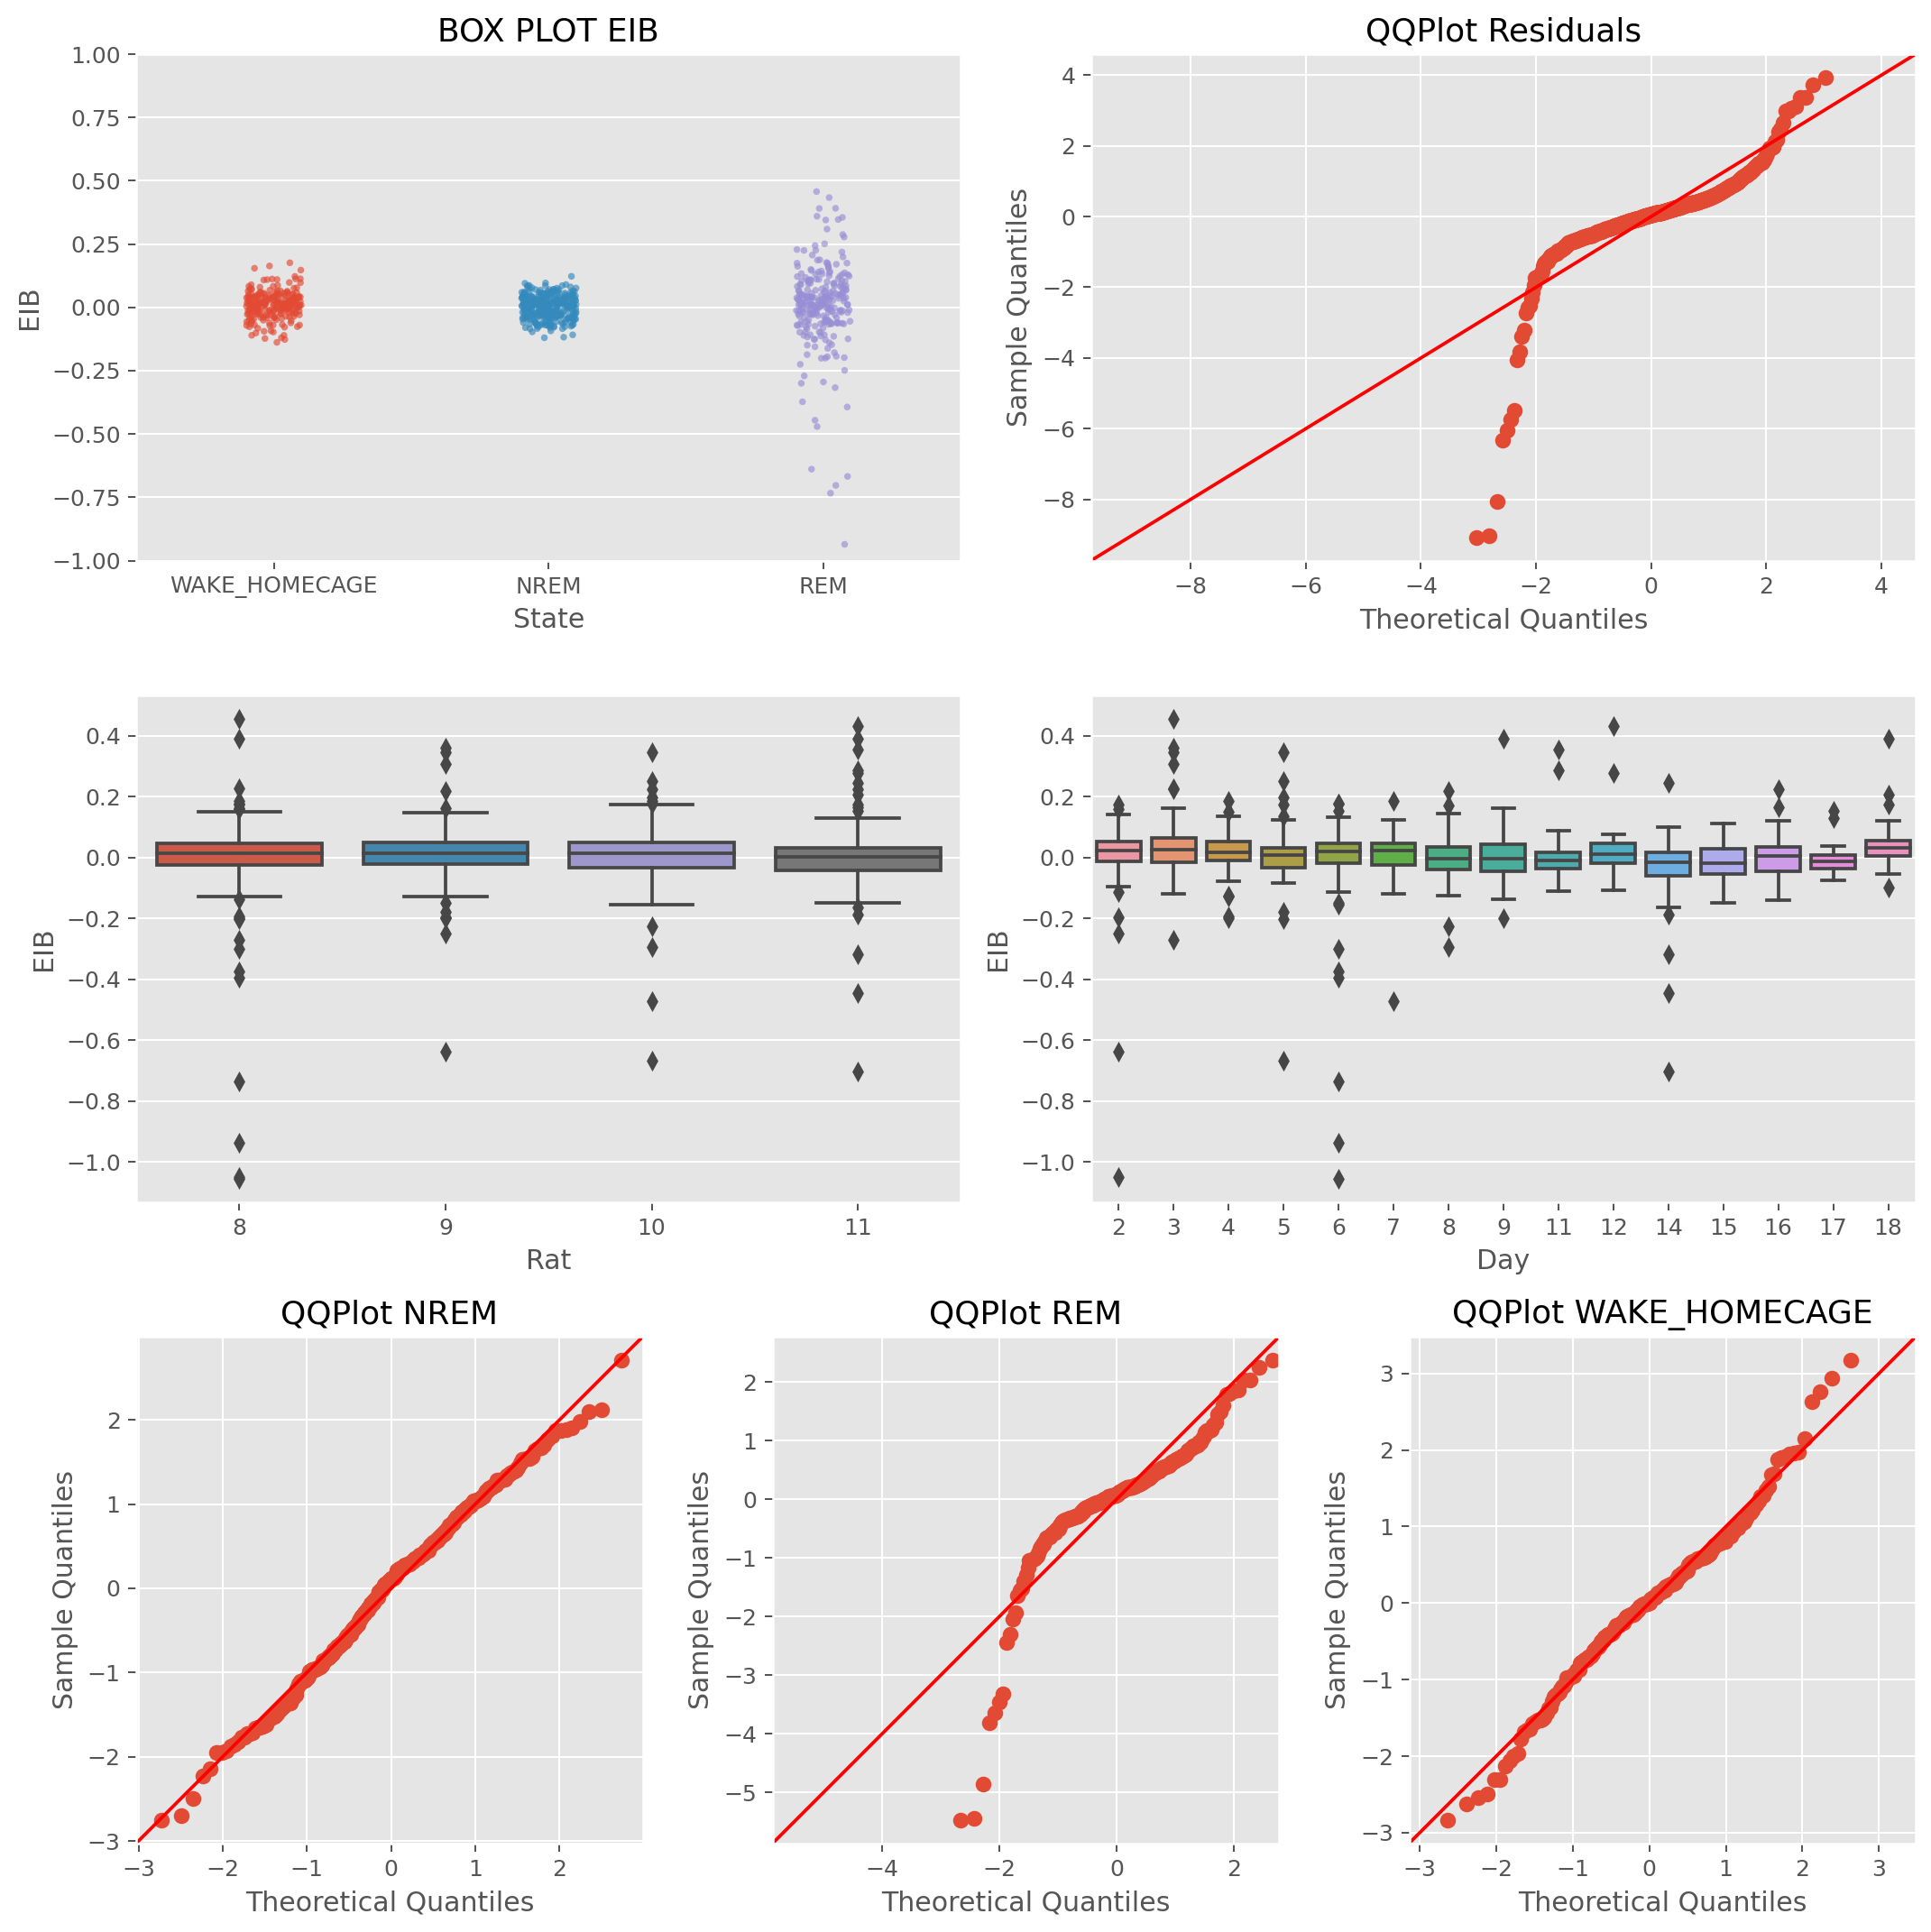

In [61]:
def anova(df, formula):
    lm = ols(formula, df).fit()
    anova_table = anova_lm(lm)
    print(anova_table)

    levene(df.EIB[df.State == 'NREM'],
           df.EIB[df.State == 'REM'],
           df.EIB[df.State == 'WAKE_HOMECAGE'])
    bartlett(df.EIB[df.State == 'NREM'],df.EIB[df.State == 'REM'])
    
    fig, ax = plt.subplot_mosaic('''
                                AAABBB
                                FFFGGG
                                CCDDEE''', dpi=180, figsize=(12, 12))
    sns.stripplot(data=df, x='State', y='EIB', ax=ax['A'],alpha = 0.65,s = 3)
    ax['A'].set_title('BOX PLOT EIB')
    ax['A'].set_ylim(-1,1)
    sm.qqplot(lm.resid, fit=True, line='45', ax=ax['B'])
    ax['B'].set_title('QQPlot Residuals')

    sns.boxplot(data=df, x='Rat', y='EIB', ax=ax['F'])
    sns.boxplot(data=df, x='Day', y='EIB', ax=ax['G'])

    for ax_, data in zip(['C', 'D', 'E'], np.unique(df.State)):
        sm.qqplot(df.EIB[df.State == data], ax=ax[ax_], fit=True, line='45')
        ax[ax_].set_title(f'QQPlot {data}')
    plt.tight_layout()

    m_comp = pairwise_tukeyhsd(df['EIB'], df['State'], alpha=0.05)
    print(m_comp.summary())
    print(m_comp.pvalues)

df = pd.concat(batch)
formula = 'EIB ~ C(State)'
anova(df,formula)
# plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures/Ongoing/EIB/EIB_Strip.svg')

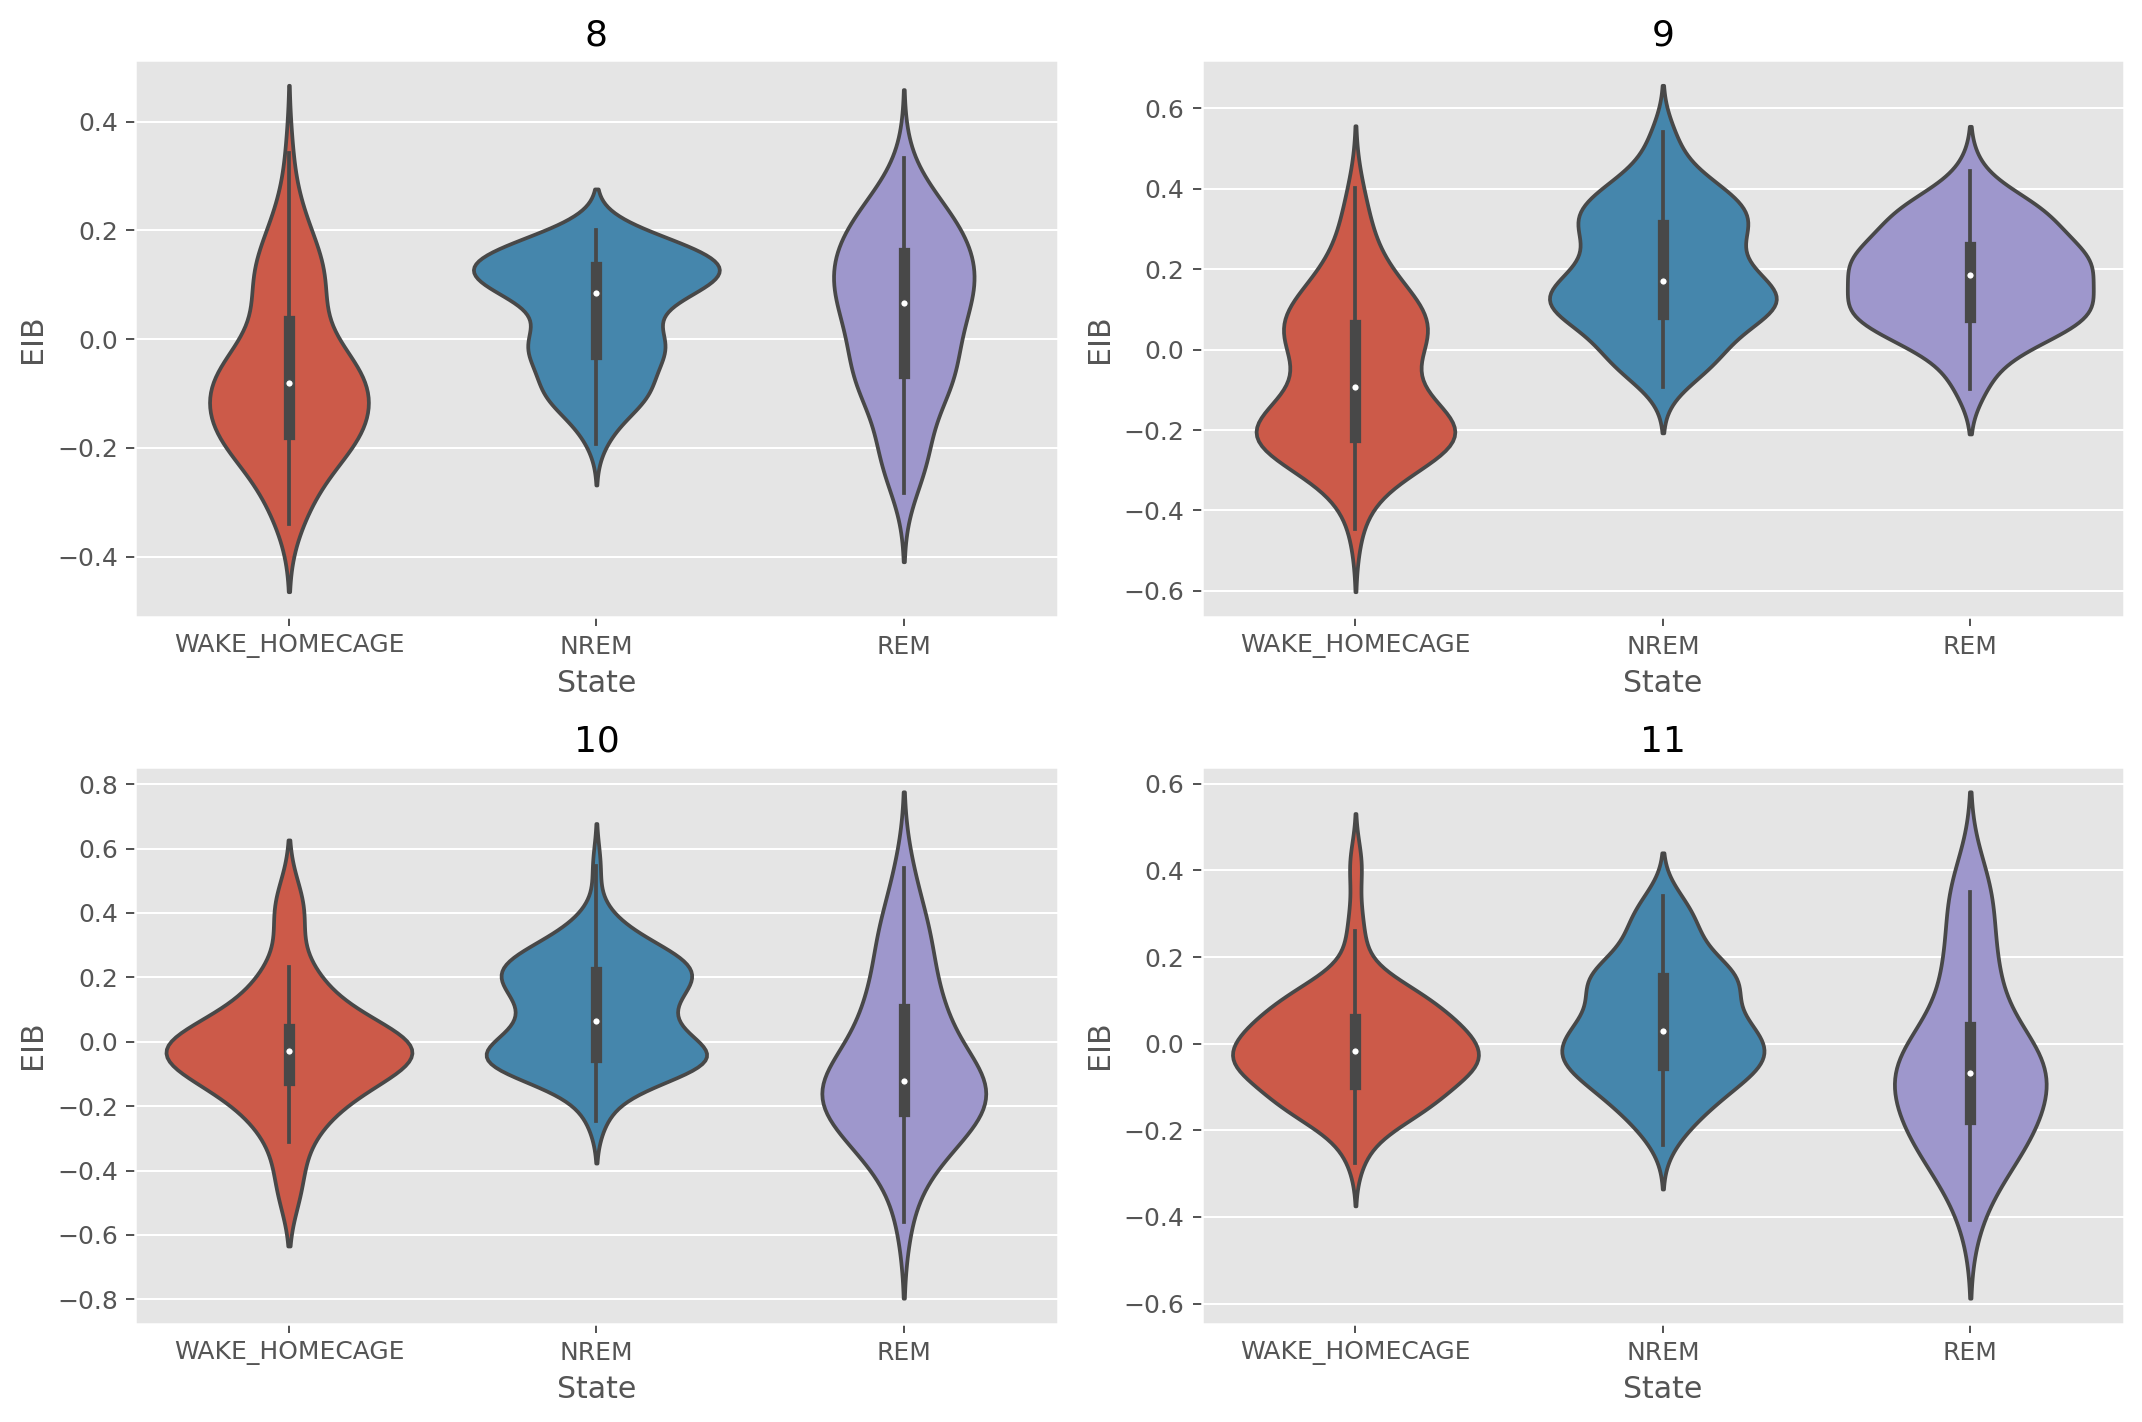

In [102]:
fig,ax = plt.subplots(2,2,figsize = (12,8),dpi = 180)

rats = [8,9,10,11]
k = 0
for i in ax:
    for j in i:
        sns.violinplot(data=df[df.Rat == rats[k]], x='State', y='EIB',ax = j)
        j.set_title(rats[k])
        k +=1

plt.tight_layout()


# Going to check EIB between theta on / theta off 

In [3]:
from imports import *

In [4]:
def discard_border(state, t):
    state.start = state.start + (t * 1_000_000)
    state.end = state.end - (t * 1_000_000)


def compute_eib(neurons, metadata, stru, start=0, stop=None, binSize=0.025, nbins=None,as_tsd = False):
    activity = bk.compute.binSpikes(neurons, start=start, stop=stop, nbins=nbins, as_Tsd=True)
    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')
    e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values, 1)
    i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values, 1)
    eib = e_spikes / (e_spikes + i_spikes)
    # eib[~np.isfinite(eib)] = np.nan
    
    if as_tsd: eib = nts.Tsd(activity.times(),eib)
    return eib

def eib_intervals(neurons,metadata,stru,intervals,nbins):
    if len(intervals) == 0:
        eib = np.empty(shape = nbins)
        eib.fill(np.nan)
        return eib
    
    intervals_eib_matrix = []
    for s,e in tqdm(intervals.as_units('s').iloc(),total = len(intervals)):
        inter = nts.IntervalSet(s,e,time_units='s')
        eib_ = compute_eib(neurons,metadata,start = s,stop = e,nbins = nbins,stru = stru)
        intervals_eib_matrix.append(eib_)
    
    return intervals_eib_matrix

In [209]:
def main(base_folder,local_path,**kwargs):
    stru = kwargs['stru']
    norm = kwargs['norm']

    bk.load.current_session_linux(base_folder=base_folder,local_path=local_path)
    neurons,metadata = bk.load.spikes()
    
    if np.sum((metadata.Region == 'BLA') & (metadata.Type == 'Int')) <5:
        raise IndexError('Less than 5 interneurons')
    
    masks = {}
    masks['STRU_PYR'] = (metadata.Region == stru) & (metadata.Type == 'Pyr')
    masks['STRU_INT'] = (metadata.Region == stru) & (metadata.Type == 'Int')

    states = bk.load.states(True)
    for s in ['wake','drowsy']: states.pop(s)
    
    baseline_intervals = states['REM'] # Baseline only during REM sleep for thetain thetaout
    baseline_eib = compute_eib(neurons,metadata,'BLA',binSize=0.1,as_tsd=True).restrict(baseline_intervals)
    baseline_mean = np.nanmean(baseline_eib.values)
    baseline_std = np.nanstd(baseline_eib.values)


    # theta_intervals = bk.load.intervals('BLA_REM_theta_bouts')
    # off_theta_intervals = states['REM'].set_diff(theta_intervals)
    # phasic_tonic = bk.load.intervals('phasic_tonic')
    
    # intervals = {'theta':theta_intervals,
    #             'theta_off':off_theta_intervals,
    #             # **phasic_tonic,
    #             'REM':states['REM']}

    gamma_intervals = bk.load.analysis('Gamma/gamma_intervals')
    gamma_left = gamma_intervals['REM']['left']['intervals']
    gamma_right = gamma_intervals['REM']['right']['intervals']
    no_gamma = states['REM'].set_diff(gamma_right.union(gamma_left))
    
    intervals = {'gamma_left':gamma_left,
                'gamma_right':gamma_right,
                'no_gamma':no_gamma}
    #Sanitary check of intervals
    # fig,ax = plt.subplots(2,sharex=True)
    # bk.plot.intervals(theta_intervals,'orange',ax = ax[0])
    # bk.plot.intervals(off_theta_intervals,'grey',ax = ax[0])
    # bk.plot.intervals(phasic_tonic['toREM'],'grey',ax = ax[1])
    # bk.plot.intervals(phasic_tonic['phREM'],'orange', ax = ax[1])
    #     
    
    all_average_eib = {}
    for k,state in intervals.items():
        state = state.drop_short_intervals(100,time_units = 'ms').reset_index(drop = True)
        activity = bk.compute.bin_by_intervals(neurons,state,as_Tsd=True)
        e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values.astype(np.int64), 1)
        i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values.astype(np.int64), 1)
        all_average_eib[k] = (e_spikes)/(e_spikes+i_spikes)
        if norm: all_average_eib[k] = (all_average_eib[k] - baseline_mean)/baseline_std


    df = {}
    for state in intervals:
        df[state] = pd.DataFrame()
        df[state]['EIB'] = all_average_eib[state]
        df[state]['State'] = state
    df = pd.concat(df)
    df['Rat'] = bk.load.rat
    df['Day'] = bk.load.day
    df = df[['Rat','Day','State','EIB']].reset_index(drop = True)
    return df

In [210]:
def anova(df, formula):

    lm = ols(formula, df).fit()
    anova_table = anova_lm(lm)
    print(anova_table)

    levene(df.EIB[df.State == 'NREM'],
           df.EIB[df.State == 'REM'],
           df.EIB[df.State == 'WAKE_HOMECAGE'])
    bartlett(df.EIB[df.State == 'NREM'],df.EIB[df.State == 'REM'])
    
    fig, ax = plt.subplot_mosaic('''
                                AAAABBBB
                                FFFFGGGG
                                CCDDEEHH''', dpi=180, figsize=(12, 12))
    sns.boxplot(data=df, x='State', y='EIB', ax=ax['A'])
    ax['A'].set_title('BOX PLOT EIB')
    sm.qqplot(lm.resid, fit=True, line='45', ax=ax['B'])
    ax['B'].set_title('QQPlot Residuals')

    sns.boxplot(data=df, x='Rat', y='EIB', ax=ax['F'])
    sns.boxplot(data=df, x='Day', y='EIB', ax=ax['G'])

    for ax_, data in zip(['C', 'D', 'E','H'], np.unique(df.State)):
        sm.qqplot(df.EIB[df.State == data], ax=ax[ax_], fit=True, line='45')
        ax[ax_].set_title(f'QQPlot {data}')
    plt.tight_layout()

    m_comp = pairwise_tukeyhsd(df['EIB'], df['State'], alpha=0.05)
    print(m_comp.summary())
    print(m_comp.pvalues)

# df = pd.concat(batch)
# formula = 'EIB ~ C(State) + C(Rat)'
# anova(df,formula)


In [211]:
kwargs = {'stru': 'BLA',
          'norm': True}
bk.load.current_session_linux()
# df = main(bk.load.base, 'Rat08/Rat08-20130713', **kwargs)
batch, metadata = bk.load.batch(main,**kwargs)

100%|██████████| 61/61 [02:48<00:00,  2.76s/it]

Batch finished in 168.33722758293152
Some session were not processed correctly
['Rat08-20130708', 'Rat08-20130715', 'Rat08-20130716', 'Rat08-20130717', 'Rat08-20130718', 'Rat08-20130719', 'Rat08-20130720', 'Rat08-20130722', 'Rat09-20140324', 'Rat09-20140325', 'Rat09-20140326', 'Rat09-20140327', 'Rat09-20140328', 'Rat09-20140329', 'Rat09-20140331', 'Rat09-20140401', 'Rat09-20140402', 'Rat09-20140403', 'Rat09-20140404', 'Rat09-20140405', 'Rat09-20140407', 'Rat09-20140408', 'Rat09-20140409', 'Rat10-20140619', 'Rat10-20140620', 'Rat10-20140622', 'Rat10-20140624', 'Rat10-20140626', 'Rat10-20140627', 'Rat10-20140628', 'Rat10-20140629', 'Rat10-20140701', 'Rat10-20140702', 'Rat10-20140703', 'Rat10-20140704', 'Rat10-20140705', 'Rat10-20140707', 'Rat10-20140708', 'Rat11-20150310', 'Rat11-20150312', 'Rat11-20150313', 'Rat11-20150314', 'Rat11-20150315', 'Rat11-20150316', 'Rat11-20150317', 'Rat11-20150321', 'Rat11-20150323', 'Rat11-20150330', 'Rat11-20150331', 'Rat11-20150401', 'Rat11-20150402', 'R

In [212]:
df = pd.concat(batch)
df = df[df.EIB.notna()]

               df       sum_sq   mean_sq         F    PR(>F)
C(State)      2.0     1.657693  0.828847  6.498258  0.001511
Residual  12542.0  1599.720291  0.127549       NaN       NaN


/home/billel/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/billel/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
 gamma_left gamma_right    0.071 0.1426 -0.0172 0.1592  False
 gamma_left    no_gamma   0.0966 0.0015  0.0315 0.1616   True
gamma_right    no_gamma   0.0256 0.5837  -0.035 0.0861  False
-------------------------------------------------------------
[0.1426126  0.00145581 0.58373033]


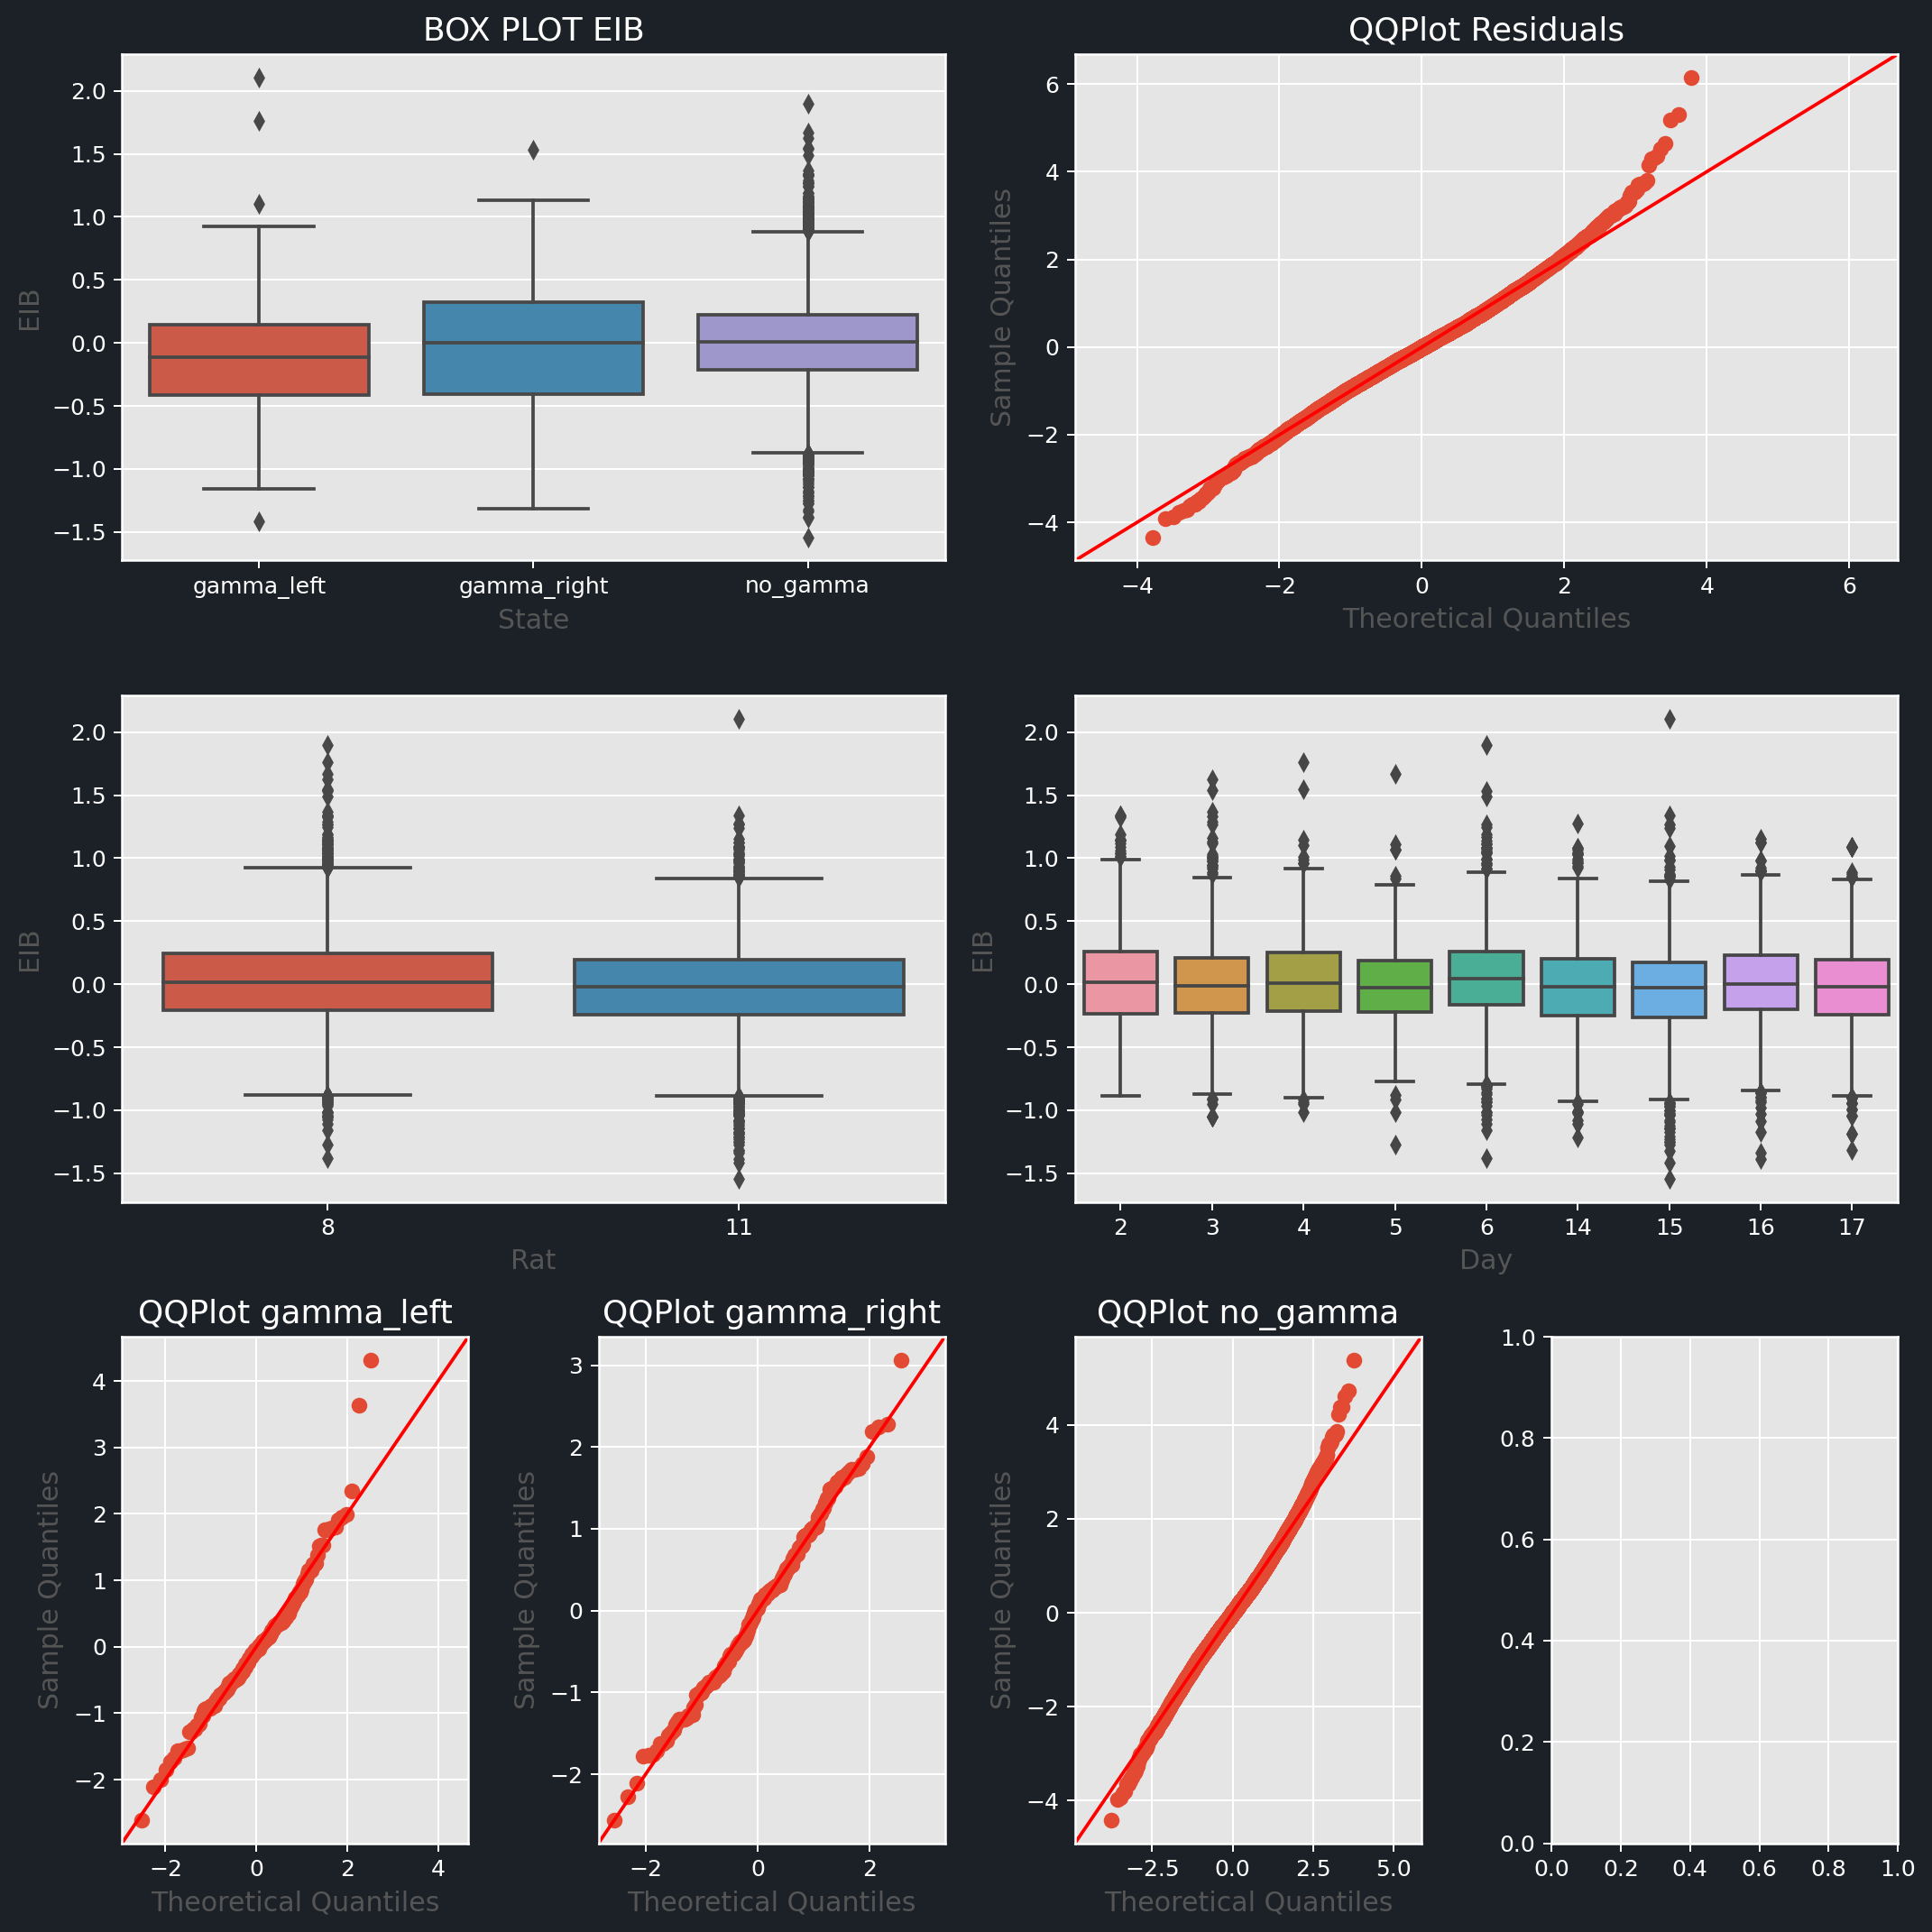

In [213]:
formula = 'EIB ~ C(State)'
anova(df,formula)

In [105]:
metadata

NameError: name 'metadata' is not defined

In [106]:
meta

,Rat,Day
Rat08-20130709,8,2
Rat08-20130710,8,3
Rat08-20130711,8,4
Rat08-20130712,8,5
Rat08-20130713,8,6
Rat09-20140325,9,2
Rat09-20140326,9,3
Rat09-20140327,9,4
Rat09-20140328,9,5
Rat09-20140329,9,6


In [3]:
from imports import * 

In [44]:
bk.load.current_session_linux()
bk.load.current_session_linux(bk.load.base,'Rat10/Rat10-20140629')
neurons, metadata = bk.load.spikes()
states = bk.load.states(True)
states.pop('drowsy')
states.pop('wake')

masks = {}
masks['STRU_PYR'] = (metadata.Region == 'BLA') & (metadata.Type == 'Pyr')
masks['STRU_INT'] = (metadata.Region == 'BLA') & (metadata.Type == 'Int')

activity = bk.compute.binSpikes(neurons,10,as_Tsd=True)

fr = {}
for i in masks:
    fr[i] = nts.Tsd(activity.times(),np.sum(activity.values[:,masks[i]],1))

e_spikes = np.sum(activity.loc[:, masks['STRU_PYR']].values.astype(np.int64), 1)
i_spikes = np.sum(activity.loc[:, masks['STRU_INT']].values.astype(np.int64), 1)
eib = e_spikes / (e_spikes + i_spikes)
eib = nts.Tsd(activity.times(),eib)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713
Rat : 10 on day : 8
Working with session Rat10-20140629 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat10/Rat10-20140629
Data already saved in Numpy format, loading them from here:
Rat10-20140629-neurons.npy
Rat10-20140629-metadata.npy


In [45]:
fig,ax  = plt.subplots()

# for c,type in zip(['g','k'],fr.keys()):
#     ax.plot(fr[type].as_units('s'),c,alpha = 0.8)
ax.plot(eib.as_units('s'),'orange')
for c,state in zip(['green','grey','orange'],states.keys()):
    bk.plot.intervals(states[state],c,ax = ax)
